The final **pupil model code**

---
This notebook is made in order to run the pupil model code and save the model parameters for each participant in order to be used later in the fusion model.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
intervals_directory = r"/content/drive/MyDrive/Data-Multimotion/Features-NEW/Intervals"
ground_truth_directory = r"/content/drive/MyDrive/Data-Multimotion/Ground truth"
results_directory = r"/content/drive/MyDrive/Data-Multimotion"

# Pupil model

Defining the imports and the paths used:

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr  1 14:10:40 2025

@author: zeelp
"""

# Import
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.pipeline import Pipeline
import lightgbm as lgb


import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import re



pupil_data = pd.read_csv(os.path.join(intervals_directory, "Interval_60_part_all_stat_features_01062025.csv"))
pupil_data.drop(columns=['Arousal', 'Valence'], inplace=True)

ground_truth_folder = r"/content/drive/MyDrive/Data-Multimotion/Ground truth/Leave-one-out/"


# Lists to store file names and extracted numbers
file_names = []
extracted_values = []

# Regex pattern to match and extract any characters (letters, numbers, underscores) after 'individual_ground_truth_no_'
pattern = re.compile(r"individual_ground_truth_no_([\w\d]+)")  # Matches letters and numbers


GT_file_val = pd.read_csv(os.path.join(ground_truth_directory, "individual_ground_truth.csv"))


# Handle Null Imputation: Impute missing values for all numeric features
imputer = SimpleImputer(strategy='mean')  # Impute missing values with the mean
numeric_columns = pupil_data.select_dtypes(include=[np.number]).columns
pupil_data[numeric_columns] = imputer.fit_transform(pupil_data[numeric_columns])


""" LOPO XGboost very well working for arousal prediction and also well for valence prediction"""

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import statistics
import pandas as pd
from sklearn.model_selection import KFold
import shap

# Assuming merged_df is already loaded as a DataFrame
participants = pupil_data['Participant'].unique()

participants = pupil_data['Participant'].unique()
r2_all, corr_list, PV, nrmse_all = [], [], [], []
p_val_heteroscedasticity_arousal = []
p_val_heteroscedasticity_valence = []

### Arousal

LOPO using pupil to predict **arousal**, using LightGBM with GridSearchCV for hyperparameter tuning. For each participant, it trains on the remaining data, evaluates on the left-out participant, saves best parameters, and computes metrics.

No ground truth file found for participant 22DFx. Skipping...
Matched file for participant 4FoNM: individual_ground_truth_no_4FoNM.csv
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1923, number of used features: 7
[LightGBM] [Info] Start training from score -0.000826




Participant: 4FoNM
Best parameters: {'learning_rate': 0.05, 'max_depth': 11, 'n_estimators': 100, 'num_leaves': 15}
No ground truth file found for participant 5BJD3. Skipping...
Matched file for participant 5KB3V: individual_ground_truth_no_5KB3V.csv
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1923, number of

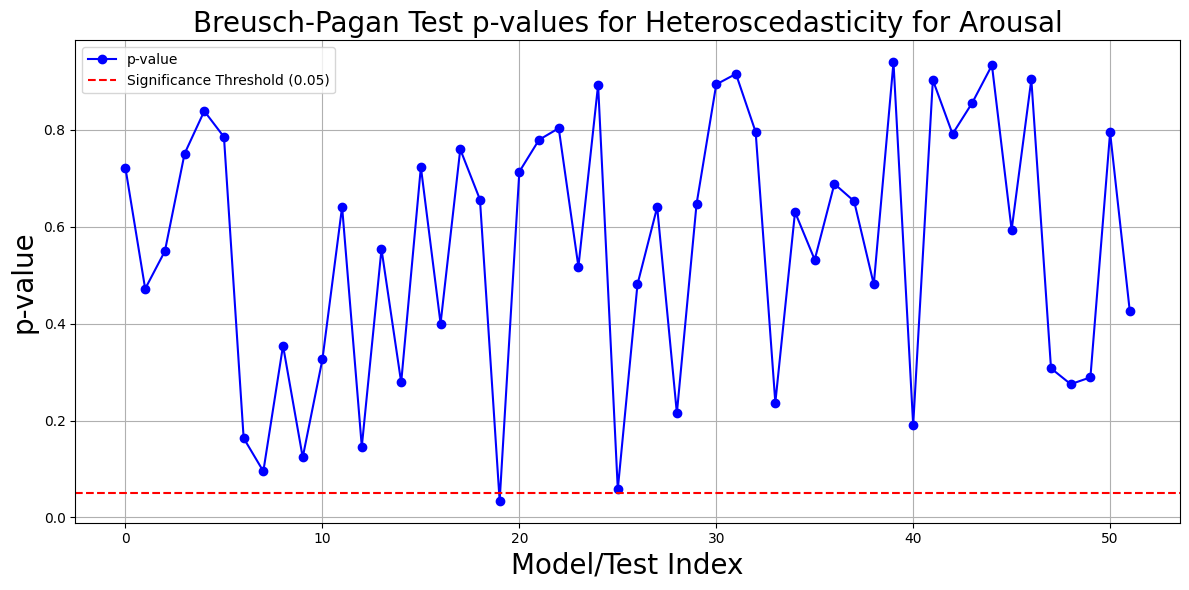

Overall R² Score across all participants for arousal: 0.6010082442027392, std: 0.25537713947012536
Overall NRMSE across all participants for arousal: 0.21201575190652774, std: 0.05276325940116027
Overall mean p-avlue across all participants for arousal: 1.0757594307789024e-05, max: 0.000558090555100576`
Overall correlation across all participants for arousal: 0.7887796944947013, std: 0.22928139491864954


In [ ]:
best_params_list = []

for i in participants:
    y_true, y_pred = [], []

    # Find corresponding ground truth file
    GT_arousal = None
    for file in os.listdir(ground_truth_folder):
        match = pattern.match(file)
        if match and i == match.group(1):
            print(f"Matched file for participant {i}: {file}")
            GT_arousal = pd.read_csv(os.path.join(ground_truth_folder, file))
            break

    if GT_arousal is None:
        print(f"No ground truth file found for participant {i}. Skipping...")
        continue

    data_train_1 = pupil_data[pupil_data['Participant'] != i]
    data_val = pupil_data[pupil_data['Participant'] == i]

    if data_val.empty:
        print(f"No validation data for participant {i}. Skipping...")
        continue

    data_val = pd.merge(
        data_val,
        GT_file_val,
        left_on=['simuli_name_1', 'Participant'],
        right_on=['Stimulus_Name', 'Participant'],
        how='inner'
    )

    if len(data_train_1) < 2:
        print(f"Not enough data for regression excluding participant {i}. Skipping...")
        continue

    if data_val.empty:
        print(f"No matching merged validation data for participant {i}. Skipping...")
        continue


    data_train = pd.merge(
        data_train_1,
        GT_arousal,
        left_on=['simuli_name_1', 'Participant'],
        right_on=['Stimulus_Name', 'Participant'],
        how='inner'
    )

    drop_cols = ['Participant', 'Arousal', 'Valence', 'Stimulus_Name', 'simuli_name_1', 'simuli_name_2', 'Unnamed: 0']
    X_train = data_train.drop(columns=[col for col in drop_cols if col in data_train.columns])
    X_train = X_train[['diff_max',
    'diff_min', 'diff_mean', 'diff_std', 'diff_kurtosis', 'diff_skewness',
    'diff_auc']]
    y_train = data_train['Arousal']

    X_val = data_val.drop(columns=[col for col in drop_cols if col in data_val.columns])
    X_val = X_val[['diff_max',
    'diff_min', 'diff_mean', 'diff_std', 'diff_kurtosis', 'diff_skewness',
    'diff_auc']]
    y_val = data_val['Arousal']


    # LightGBM GridSearchCV
    lgb_model = lgb.LGBMRegressor(random_state=42)

    param_grid = {
        'learning_rate': [0.01, 0.1, 0.05, 0.5],
        'n_estimators': [50, 100, 200, 250, 300],
        'max_depth': [3, 5, 7, 9, 11],
        'num_leaves': [15, 31, 63, 85, 100]
    }

    grid = GridSearchCV(estimator=lgb_model, param_grid=param_grid,
                        cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print(f"\n\n\n\nParticipant: {i}")
    print("Best parameters:", grid.best_params_)
    y_pred_test = best_model.predict(X_val)
    best_params_list.append({
        'Participant': i,
        **grid.best_params_
    })


    # Compute metrics
    mse = mean_squared_error(y_val, y_pred_test)
    r2 = r2_score(y_val, y_pred_test)

    # Heteroscedasticity test
    residuals = y_val - y_pred_test
    X_bp = sm.add_constant(y_pred_test)
    model = sm.OLS(residuals**2, X_bp).fit()
    test = het_breuschpagan(model.resid, model.model.exog)
    bp_p_value = test[1]

    p_val_heteroscedasticity_arousal.append(bp_p_value)


    # Collect metrics for overall reporting
    rmse = np.sqrt(mse)
    nrmse = rmse / (max(y_val) - min(y_val))

    r2_all.append(r2)
    corr, p_val = pearsonr(y_val, y_pred_test)
    corr_list.append(corr)
    PV.append(p_val)
    nrmse_all.append(nrmse)

best_params_df = pd.DataFrame(best_params_list)
best_params_df.to_csv('pupil_params_arousal.csv', index=False)

corr_series = pd.Series(corr_list)
cleaned_corr_list = corr_series.dropna()


# Calculate overall results
overall_r2 = statistics.mean(r2_all)
overall_nrmse = statistics.mean(nrmse_all)
overall_p_val = statistics.mean(PV)
overall_corr = statistics.mean(corr_list)


# Create a simple plot
plt.figure(figsize=(12, 6))
plt.plot(p_val_heteroscedasticity_arousal, marker='o', linestyle='-', color='blue', label='p-value')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Breusch-Pagan Test p-values for Heteroscedasticity for Arousal', fontsize = 20)
plt.xlabel('Model/Test Index', fontsize = 20)
plt.ylabel('p-value', fontsize = 20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Overall R² Score across all participants for arousal: {overall_r2}, std: {statistics.stdev(r2_all)}")
print(f"Overall NRMSE across all participants for arousal: {overall_nrmse}, std: {statistics.stdev(nrmse_all)}")
print(f"Overall mean p-avlue across all participants for arousal: {overall_p_val}, max: {max(PV)}`")
print(f"Overall correlation across all participants for arousal: {overall_corr}, std: {statistics.stdev(corr_list)}")



### Valence

LOPO using pupil to predict **valence**, using LightGBM with GridSearchCV for hyperparameter tuning. For each participant, it trains on the remaining data, evaluates on the left-out participant, saves best parameters, and computes metrics.

No ground truth file found for participant 22DFx. Skipping...
Participant 4FoNM already processed. Skipping...
No ground truth file found for participant 5BJD3. Skipping...
Participant 5KB3V already processed. Skipping...
Participant 6GSd4 already processed. Skipping...
Participant 7yqP3 already processed. Skipping...
Participant 8vDRG already processed. Skipping...
No ground truth file found for participant 9FGka. Skipping...
Participant A5feTy already processed. Skipping...
Participant Bs73 already processed. Skipping...
Participant CoQmx already processed. Skipping...
Participant Cr1sTi already processed. Skipping...
Participant CVgs2 already processed. Skipping...
Participant D9Hh9 already processed. Skipping...
Participant Dwf5T already processed. Skipping...
No ground truth file found for participant EJOiBs. Skipping...
Participant ERqc8 already processed. Skipping...
Participant EXAMPLE already processed. Skipping...
Participant F5tXL already processed. Skipping...
Participant F

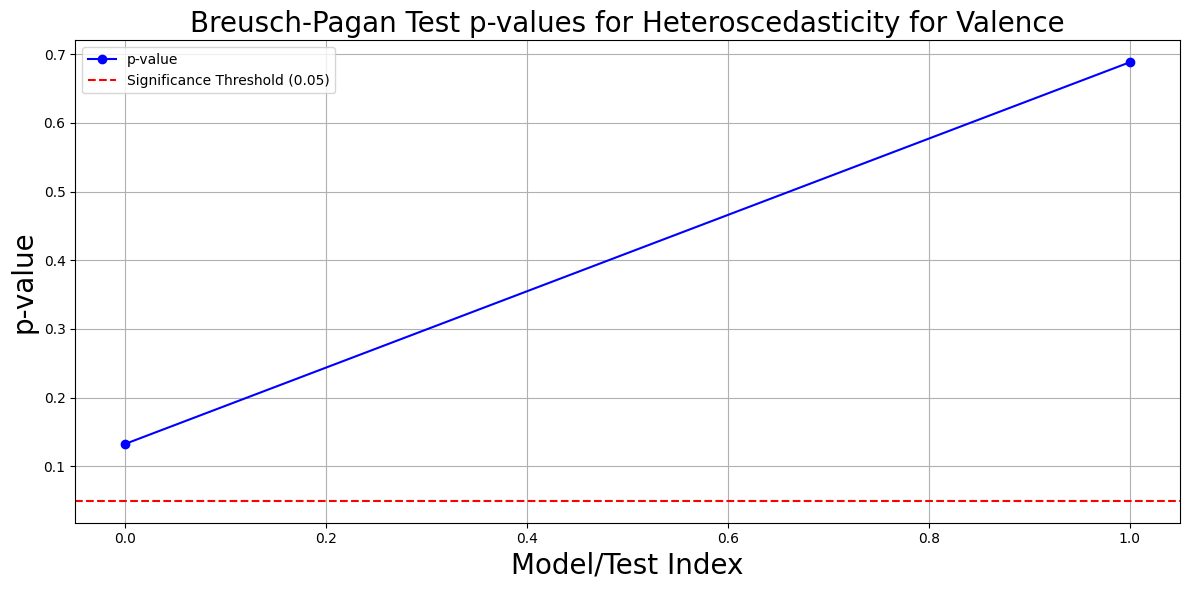

Overall R² Score across all participants for valence: 0.6034740608149674, std: 0.18624498888693142
Overall NRMSE across all participants for valence: 0.20656052869437486, std: 0.04999785430210704
Overall mean p-avlue across all participants for valence: 6.847298746335076e-07, max: 1.369459158156706e-06`
Overall correlation across all participants for valence: 0.788401216656998, std: 0.12395439859237033


In [ ]:
import os
""" for Valence """
results_folder = r"/content/drive/MyDrive/Data-Multimotion"
save_path = os.path.join(results_folder, "pupil_params_valence.csv")

best_params_list_v = []
if os.path.exists(save_path):
    processed_df = pd.read_csv(save_path)
    processed_participants = set(processed_df['Participant'].astype(str))
else:
    processed_participants = set()

r2_all_v, corr_list_v, PV_v, nrmse_all_v = [], [], [], []

for i in participants:
    if str(i) in processed_participants:
      print(f"Participant {i} already processed. Skipping...")
      continue
      y_true, y_pred = [], []

    # Find corresponding ground truth file
    GT_arousal = None
    for file in os.listdir(ground_truth_folder):
        match = pattern.match(file)
        if match and i == match.group(1):
            print(f"Matched file for participant {i}: {file}")
            GT_arousal = pd.read_csv(os.path.join(ground_truth_folder, file))
            break

    if GT_arousal is None:
        print(f"No ground truth file found for participant {i}. Skipping...")
        continue

    data_train_1 = pupil_data[pupil_data['Participant'] != i]
    data_val = pupil_data[pupil_data['Participant'] == i]

    if data_val.empty:
        print(f"No validation data for participant {i}. Skipping...")
        continue

    data_val = pd.merge(
        data_val,
        GT_file_val,
        left_on=['simuli_name_1', 'Participant'],
        right_on=['Stimulus_Name', 'Participant'],
        how='inner'
    )

    if len(data_train_1) < 2:
        print(f"Not enough data for regression excluding participant {i}. Skipping...")
        continue

    if data_val.empty:
        print(f"No matching merged validation data for participant {i}. Skipping...")
        continue


    data_train = pd.merge(
        data_train_1,
        GT_arousal,
        left_on=['simuli_name_1', 'Participant'],
        right_on=['Stimulus_Name', 'Participant'],
        how='inner'
    )

    drop_cols = ['Participant', 'Arousal', 'Valence', 'Stimulus_Name', 'simuli_name_1', 'simuli_name_2', 'Unnamed: 0']
    X_train = data_train.drop(columns=[col for col in drop_cols if col in data_train.columns])
    y_train = data_train['Valence']

    X_val = data_val.drop(columns=[col for col in drop_cols if col in data_val.columns])
    y_val = data_val['Valence']


    # LightGBM GridSearchCV
    lgb_model = lgb.LGBMRegressor(objective='quantile', alpha=0.5, random_state=42)

    param_grid = {
        'learning_rate': [0.01, 0.1, 0.05,0.2],
        'n_estimators': [50, 100, 200, 250, 300],
        'max_depth': [3, 5, 7, 9, 11],
        'num_leaves': [15, 31, 63, 85, 101]
    }


    grid = GridSearchCV(estimator=lgb_model, param_grid=param_grid,
                        cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"\n\n\n\nParticipant: {i}")
    print("Best parameters:", grid.best_params_)
    best_model = grid.best_estimator_
    # Append best parameters
    best_params_list_v.append({
        'Participant': i,
        **grid.best_params_
    })

    # Save incrementally after each participant
    results_folder = r"/content/drive/MyDrive/Data-Multimotion"
    save_path = os.path.join(results_folder, "pupil_params_valence.csv")

    # Convert to DataFrame with only the last entry
    best_params_df_i = pd.DataFrame([best_params_list_v[-1]])

    # Write header only if this is the first participant being processed
    write_header = not os.path.exists(save_path)
    best_params_df_i.to_csv(save_path, mode='a', header=write_header, index=False)


    y_pred_test = best_model.predict(X_val)

    if len(y_pred_test) == 0 or len(y_val) == 0:
        print(f"Skipping participant {i} due to empty predictions or labels.")
        continue

    mse = mean_squared_error(y_val, y_pred_test)
    r2 = r2_score(y_val, y_pred_test)

    # Heteroscedasticity test
    residuals = y_val - y_pred_test
    X_bp = sm.add_constant(y_pred_test)
    model = sm.OLS(residuals**2, X_bp).fit()
    test = het_breuschpagan(model.resid, model.model.exog)
    p_val_heteroscedasticity_valence.append(test[1])

    rmse = np.sqrt(mse)
    nrmse = rmse / (max(y_val) - min(y_val))

    r2_all_v.append(r2)
    corr_v, p_val_v = pearsonr(y_val, y_pred_test)
    corr_list_v.append(corr_v)
    PV_v.append(p_val_v)
    nrmse_all_v.append(nrmse)

corr_series = pd.Series(corr_list)
cleaned_corr_list = corr_series.dropna()

# Calculate overall results
overall_r2 = statistics.mean(r2_all_v)
overall_nrmse = statistics.mean(nrmse_all_v)
overall_p_val = statistics.mean(PV_v)
overall_corr = statistics.mean(corr_list_v)


# Create a simple plot
plt.figure(figsize=(12, 6))
plt.plot(p_val_heteroscedasticity_valence, marker='o', linestyle='-', color='blue', label='p-value')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Breusch-Pagan Test p-values for Heteroscedasticity for Valence', fontsize = 20)
plt.xlabel('Model/Test Index', fontsize = 20)
plt.ylabel('p-value', fontsize = 20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"Overall R² Score across all participants for valence: {overall_r2}, std: {statistics.stdev(r2_all_v)}")
print(f"Overall NRMSE across all participants for valence: {overall_nrmse}, std: {statistics.stdev(nrmse_all_v)}")
print(f"Overall mean p-avlue across all participants for valence: {overall_p_val}, max: {max(PV_v)}`")
print(f"Overall correlation across all participants for valence: {overall_corr}, std: {statistics.stdev(corr_list_v)}")

